In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function, division
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# interactive mode
plt.ion()   


# Data normalization

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = '/content/drive/MyDrive/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=2,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
torch.cuda.is_available()

False

In [ ]:
dataset_sizes

{'test': 20, 'train': 337, 'val': 20}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


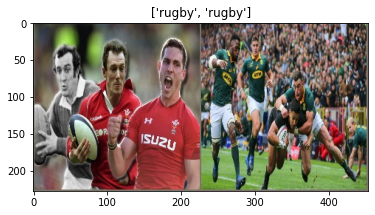

In [ ]:

inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
  
    losses = defaultdict(list)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

  
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            losses[phase].append(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses

In [ ]:
def visualize_model(model, num_images=6, folder = 'val'):
  # ?
    was_training = model.training
    model.eval()

    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[folder]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)

                    return
        model.train(mode=was_training)

In [ ]:
def test_accuracy(model):
    was_training = model.training
    model.eval()
    res = []
    true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            true.extend(labels.tolist())
            res.extend(preds.tolist())


        model.train(mode=was_training)
    return res, true

In [ ]:

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


In [ ]:
model_ft = models.resnet50(pretrained=True)

    
    
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)



model_ft = model_ft.to(device)

criterion = LabelSmoothingLoss(classes=len(class_names))

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
torch.cuda.is_available()

False

In [ ]:
model_ft,losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9751 Acc: 0.6261
val Loss: 0.5722 Acc: 0.7000

Epoch 1/14
----------
train Loss: 0.9982 Acc: 0.6855
val Loss: 0.8826 Acc: 0.8000

Epoch 2/14
----------
train Loss: 0.8466 Acc: 0.7092
val Loss: 0.4809 Acc: 0.8500

Epoch 3/14
----------
train Loss: 0.6844 Acc: 0.6914
val Loss: 0.3586 Acc: 0.8500

Epoch 4/14
----------
train Loss: 0.4218 Acc: 0.8220
val Loss: 0.3202 Acc: 0.8500

Epoch 5/14
----------
train Loss: 0.2435 Acc: 0.9021
val Loss: 0.5379 Acc: 0.7500

Epoch 6/14
----------
train Loss: 0.1981 Acc: 0.9258
val Loss: 0.3332 Acc: 0.9500

Epoch 7/14
----------
train Loss: 0.0916 Acc: 0.9792
val Loss: 0.4415 Acc: 0.9500

Epoch 8/14
----------
train Loss: 0.0815 Acc: 0.9852
val Loss: 0.3504 Acc: 0.9500

Epoch 9/14
----------
train Loss: 0.0499 Acc: 0.9941
val Loss: 0.3667 Acc: 0.9500

Epoch 10/14
----------
train Loss: 0.0749 Acc: 0.9763
val Loss: 0.3485 Acc: 0.9500

Epoch 11/14
----------
train Loss: 0.0625 Acc: 0.9881
val Loss: 0.3906 Acc: 0.9500

Epoch 12/14
----------
t

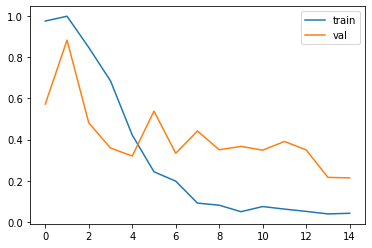

In [ ]:
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend()

In [ ]:
pred, true = test_accuracy(model_ft)
acc = [1 for j in range(len(pred)) if pred[j] == true[j]]
preds = defaultdict(list)
trues = defaultdict(list)
for i in range(len(pred)):
    trues[str(true[i])].append(1)
    if pred[i] == true[i]:
        preds[str(true[i])].append(1)
    else:
        preds[str(true[i])].append(0)
        
from collections import OrderedDict
import pandas as pd
res = OrderedDict()
for label in preds.keys():
    res[label] ={}
    y_t = trues[label]
    y_p = preds[label]
    
    res[label]['precision_score'] = precision_score(y_t, y_p)
    res[label]['recall_score'] = recall_score(y_t, y_p)
    res[label]['f1_score'] = f1_score(y_t, y_p)
res = pd.DataFrame(res)   
res.transpose()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


,precision_score,recall_score,f1_score
1,1.0,1.0,1.0
0,1.0,1.0,1.0


In [ ]:
len(acc)/len(pred)

1.0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


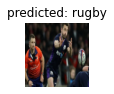

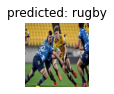

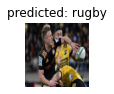

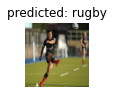

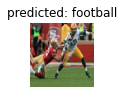

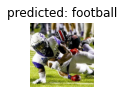

In [ ]:
visualize_model(model_ft)
plt.ioff()

In [ ]:
torch.save(model_ft.state_dict(),
                   'sport_classifier.pth')
!ls

drive  sample_data  sport_classifier.pth


In [ ]:
model_ft = models.resnet50()
device = 'cpu'
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.load_state_dict(torch.load('/content/sport_classifier.pth'))
model_ft = model_ft.to(device)
model_ft.eval()


transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def classify_imgs(file):
    img = Image.open(file)
    img_ = transform(img)
    with torch.no_grad():
        res = []
        inputs = img_.to(device)
        outputs = model_ft(inputs[None, ...])
        prob = torch.nn.functional.softmax(outputs,dim = 1)[0]
        _, preds = torch.max(outputs, 1)
        res.extend(preds.tolist())
        if res[0] == 0:
            label = 'class 1'
        else:
            label = 'class 2'
        
    return label, _round(prob[preds[0]].item())